In [1]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

hr:  2.3333333333333335


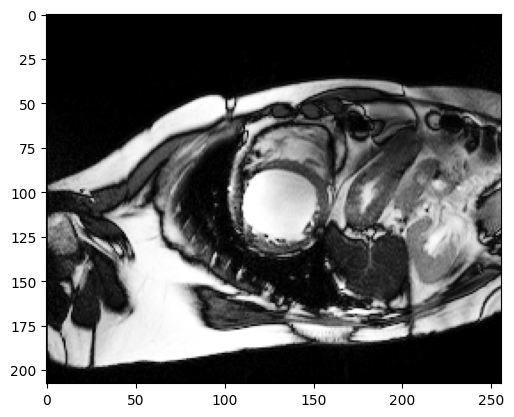

In [88]:
Tps = 0
Slice = 5

num = 10




def load_patient(num):
    with open(f'database/patient{num:03}/info.cfg') as f:
        info = [line.replace("\n", "").replace(":", "").split(" ") for line in f]
        for i in range(len(info)):
            if info[i][1].isnumeric():
                info[i][1] = int(info[i][1])

    patient = tio.Subject(
        img=tio.ScalarImage(f'database/patient{num:03}/patient{num:03}_4d.nii.gz'),
        gt=tio.LabelMap(f'database/patient{num:03}/patient{num:03}_frame{dict(info)["ED"]:02}_gt.nii.gz'),
        info = dict(info)
    )
    return patient



def normalize(img4d):
    hist = torch.linspace(0, 1, img4d.shape[1]*img4d.shape[2]*img4d.shape[3])
    hist = torch.pow(hist, 5)*(6-5*hist)
    for t in range(img4d.shape[0]):
        indexs = torch.unravel_index(torch.argsort(img4d[t].flatten()), img4d[t].shape)
        img4d[t][indexs] = hist


patient = load_patient(num)
t_img = patient.img.data.clone().detach()
normalize(t_img)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')

print("hr: ", t_img.shape[0] / (patient.info["ES"] - patient.info["ED"]))

In [89]:
def get_target(patient):
    t_gt = torch.tensor(patient.gt.data)
    center = (t_gt[0, :, :, Slice]==3).argwhere().mean(axis=0, dtype=torch.float32)
    return center

In [90]:
def tf_mask(image4d, Tps=Tps, Slice=Slice, heartrate=2):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    # interpolation frequance cardiaque
    heartrate_i = int(heartrate)
    heartrate_f = heartrate - heartrate_i
    filtred[:heartrate_i, :, :, :] = 0.0
    filtred[heartrate_i+1:, :, :, :] = 0.0
    filtred[heartrate_i] *= (1-heartrate_f)
    filtred[heartrate_i+1] *= heartrate_f

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = np.ones((19, 19), np.uint8) 
    mask = cv2.dilate(mask, kernel, 1)
    mask = cv2.blur(mask,(21, 21))
    # print(np.max(mask))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m


In [91]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
      cv2.circle(cimg,(i[0],i[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

In [109]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image, Tps=Tps, Slice=Slice):
    param_min = 0
    param_max = 200
    for _ in range(12):
        param_mean = (param_min + param_max) / 2
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circles is not None and len(circles[0])==1:
            return circles, param_mean
        
        elif circles is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return None, None

def best_hough_max(image, Tps=Tps, Slice=Slice):
    param_min = 0
    param_max = 200
    out_circles = None
    for _ in range(10):
        param_mean = (param_min + param_max) / 2
        circle = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param_mean,param2=param_mean/2,minRadius=0,maxRadius=0)
        
        if circle is not None and len(circle[0])==1:
            out_circles = circle
            param_min = param_mean

        elif circle is None:
            param_max = param_mean
        
        else:
            param_min = param_mean

    return out_circles, (param_min + param_max) / 2

def best_hough2(image, Tps=Tps, Slice=Slice):
    for param1 in range(180, 20, -5):
    #for param1 in range(20, 180, 10):
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param1/2,minRadius=1,maxRadius=50)
        
        if circles is not None and len(circles[0])==1:
            return circles, param1
    return None, -1

In [110]:
def find_seed(patient, i=0):
    t_img = torch.tensor(patient.img.data, dtype=torch.float32)
    #normalize(t_img)
    hr = t_img.shape[0] / (patient.info["ES"] - patient.info["ED"])
    img_m = tf_mask(t_img, heartrate=hr)
    circles, param1 = best_hough2(img_m)
    return circles



def recherche_cercles(nb):
    avg_dist = 0
    miss = 0
    accuracie = 0
    for i in range (1,nb+1):
        patient = load_patient(i)
        circles = find_seed(patient, i)
        t_img = torch.tensor(patient.img.data, dtype=torch.float32)
        c_img = draw_cercles(t_img, circles)
        gt = get_target(patient)


        if circles is None:
            miss += 1
        else:
            avg_dist += 1/nb*torch.dist(gt, torch.tensor(circles[0, 0, :2])) 
            gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)
            if gt_map[0, int(circles[0, 0, 1]), int(circles[0, 0, 0]), Slice] == 3:
                accuracie += 1 

        cv2.imwrite(f'test/cercles_{i:03d}.png', c_img)
    print("miss:", miss, ", avg dist:", avg_dist, ", accu:", accuracie)


In [111]:
recherche_cercles(100)

# best_hough miss 21/100, miss: 4 avg dist: tensor(44.6861)
# best_hough_max miss 21/100, miss: 4 avg dist: tensor(44.7587)
# best_hough2 miss: 0 avg dist: tensor(46.5124)

# hough2+norm: miss: 21 avg dist: tensor(36.6959) accu: 70
# hough2

C:\Users\debat\AppData\Local\Temp\ipykernel_7988\2830992540.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_7988\2830992540.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data, dtype=torch.float32)
C:\Users\debat\AppData\Local\Temp\ipykernel_7988\2830992540.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_map = torch.tensor(patient.gt.data, dtype=torch.int32)


miss: 10 , avg dist: tensor(40.6868) , accu: 81
